# Part IV. Verify intensity differences

- Let's plot the colonies that were reported with high intensity differences to visually check that they make sense and it is not just an illumination artifact.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from glob import glob
import os

import pandas as pd
from scipy import ndimage
from importlib import reload
from skimage import exposure

In [2]:
fs = 15

data = pd.read_csv('..' + os.sep + 'library_eY2H.csv')

src = '..' + os.sep + 'proc' + os.sep
lsrc = src + 'leyre' + os.sep
msrc = src + 'mather' + os.sep
dst = '..' + os.sep + 'proc' + os.sep
diagdst = '..' + os.sep + 'diagnostic' + os.sep

lgenes = os.listdir(lsrc)
mgenes = os.listdir(msrc)
print('Reference:\t', mgenes, '\nGenes to test:\t', lgenes, sep='')

Reference:	['p53']
Genes to test:	['LBD37']


In [3]:
lgidx, mgidx = 0,0
print('Comparing gene', lgenes[lgidx], 'with reference', mgenes[mgidx] )
gdst = dst + lsrc.split(os.sep)[-2] + os.sep + lgenes[lgidx] + os.sep
mdst = dst + msrc.split(os.sep)[-2] + os.sep + mgenes[mgidx] + os.sep
print('Will save all results in ',gdst)
ddst = diagdst + lsrc.split(os.sep)[-2] + os.sep + lgenes[lgidx] + os.sep

Comparing gene LBD37 with reference p53
Will save all results in  ../proc/leyre/LBD37/


In [13]:
platenum = 6

ref_file = glob(msrc + mgenes[mgidx] + os.sep + '*_{:02d}_colormatrix.csv'.format(platenum) )[0]
plate_file = glob(lsrc + lgenes[lgidx] + os.sep + '*_{:02d}_colormatrix.csv'.format(platenum) )[0]
bname = '_'.join((os.path.split(os.path.splitext(plate_file)[0])[1]).split('_')[:-1])

print(ref_file, plate_file, bname, sep='\n')

../proc/mather/p53/p53_plate_06_colormatrix.csv
../proc/leyre/LBD37/20231130_plate_06_colormatrix.csv
20231130_plate_06


In [36]:
rsrc = '..' + os.sep + 'raw' + os.sep 
rawimg_file = os.path.split(ref_file)[0].replace(src,rsrc) + os.sep
rawimg_file = glob(rawimg_file + '*_{:02d}*'.format(platenum))[0]
rname = os.path.split(os.path.splitext(rawimg_file)[0])[1]

pltimg_file = os.path.split(plate_file)[0].replace(src,rsrc) + os.sep
pltimg_file = glob(pltimg_file + '*_{:02d}*'.format(platenum))[0]
bname = os.path.split(os.path.splitext(pltimg_file)[0])[1]

print(rawimg_file, pltimg_file, rname, bname, sep='\n')

../raw/mather/p53/p53_plate_06.jpg
../raw/leyre/LBD37/20231130_plate_06.JPG
p53_plate_06
20231130_plate_06


In [39]:
import utils
rawimg = utils.load_image(rawimg_file, check_rotation=True)

filename = mdst + rname + '_plateslice.csv'
meta = np.loadtxt(filename, delimiter=',', dtype=int)
plateslice = np.s_[ meta[0]:meta[1], meta[2]:meta[3] ]
rawimg = rawimg[plateslice]
filename = mdst + rname + '_centers.npy'
rawcoords = np.load(filename, allow_pickle=True)

pltimg = utils.load_image(pltimg_file, check_rotation=True, color_check=1)

filename = gdst + bname + '_plateslice.csv'
meta = np.loadtxt(filename, delimiter=',', dtype=int)
plateslice = np.s_[ meta[0]:meta[1], meta[2]:meta[3] ]
pltimg = pltimg[plateslice]
filename = gdst + bname + '_centers.npy'
pltcoords = np.load(filename, allow_pickle=True)

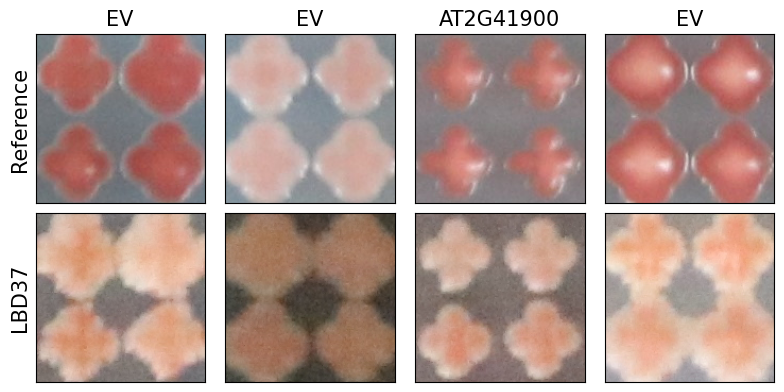

In [42]:
fs = 15
R = 80
figR = 2
fig, ax = plt.subplots(2,len(signif), figsize=(len(signif)*figR, 2*figR), sharex=True, sharey=True)
ax = ax.reshape(2, len(signif))

for i in range(len(signif)):
    j = 0
    row, col = [int(foo[1:])-1 for foo in signif.iloc[i,1].split('-')[1:] ]
    
    ax[0,i].set_title(signif.iloc[i,0], fontsize=fs)
    for (cc,img) in zip([rawcoords, pltcoords],[rawimg,pltimg]):
        dots = cc[2*row : 2*row + 2, 2*col : 2*col + 2]
        center = np.mean(np.mean(dots, axis = 0), axis = 0).astype(int)
        rss = np.s_[center[1] - R : center[1] + R, center[0] - R : center[0] + R]
        ax[j,i].imshow(img[rss], vmin=0, origin='upper'); j+=1
ax[0,0].set_ylabel('Reference', fontsize=fs)
ax[1,0].set_ylabel(lgenes[lgidx], fontsize=fs)
for a in ax.ravel():
    a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

fig.tight_layout();
#plt.savefig('foo.jpg', dpi=200, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

In [43]:
ddst

NameError: name 'ddst' is not defined